In [ ]:
pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-1_l6voeg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-1_l6voeg
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 1e0b1d9c727e8d1a11df5c25a0722c3f9e12711b
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.10.tar.gz (42 kB)
  Preparing metadata (setup.py) ... done
  Using cached portalocker-2.10.1-py3-none-any.whl.metadata (8.5 kB)
Using cached portalocker-2.10.1-py3-none-any.whl (18 kB)
ERROR: Operation cancelled by user


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import torch
from pytorch3d.loss import chamfer_distance as chamfer_dist

ModuleNotFoundError: No module named 'pytorch3d'

In [ ]:
class Tnet(nn.Module):
    def __init__(self, dim, num_points=2000):
        super(Tnet, self).__init__()
        self.dim = dim

        self.conv1 = nn.Conv1d(self.dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        # Correct max pool
        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

        # Linear layers to create transformation matrices
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)  # Ensure correct output size

    def forward(self, x):
        bs = x.shape[0]

        # Pass through the layers
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # Max pool and reshape
        x = self.max_pool(x).view(bs, -1)

        # Fully connected layers
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x.view(bs, self.dim, self.dim)

In [ ]:
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=2000, num_global_feats=1024, local_feat=False):
        super(PointNetBackbone, self).__init__()

        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # Convolutional layers and batch normalization
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

        # MLP with feature transformation
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, num_global_feats, kernel_size=1)

        self.bn3 = nn.BatchNorm1d(64)  # Fixing error by keeping the same dimension
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(num_global_feats)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    def forward(self, x):
        transform = self.tnet1(x)  # Spatial transformation
        x = torch.bmm(x.transpose(2, 1), transform).transpose(2, 1)

        # Pass through layers with batch normalization
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        feat_transform = self.tnet2(x)  # Feature transformation
        x = torch.bmm(x.transpose(2, 1), feat_transform).transpose(2, 1)

        # Further MLPs and max pooling
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.max_pool(x).view(x.shape[0], -1)

        return x, transform, feat_transform

In [ ]:
# GlobalFeatureExtraction class
class GlobalFeatureExtraction(nn.Module):
    def __init__(self, num_points=2000, num_global_feats=1024):
        super(GlobalFeatureExtraction, self).__init__()

        # PointNet instances for each point cloud
        self.pnet1 = PointNetBackbone(num_points=num_points, num_global_feats=1024, local_feat=False)
        self.pnet2 = PointNetBackbone(num_points=num_points, num_global_feats=1024, local_feat=False)

    def forward(self, source_x, target_x):
        # Get global features from PointNet
        source_result = self.pnet1(source_x)
        target_result = self.pnet2(target_x)

        source_global_features = source_result[0]  # Shape: [batch_size, 1024]
        target_global_features = target_result[0]  # Shape: [batch_size, 1024]

        # Concatenate global features (2048-dimensional vector)
        concatenated_features = torch.cat((source_global_features, target_global_features), dim=1)  # Shape: [batch_size, 2048]

        # Extract source point coordinates
        source_coordinates = source_x.permute(0, 2, 1)  # Shape: [batch_size, 2000, 3]

        # Expand concatenated features to align with source points' shape
        expanded_features = concatenated_features.unsqueeze(2).expand(-1, -1, source_coordinates.shape[1])  # Shape: [batch_size, 2048, 2000]

        # Concatenate expanded features with point coordinates
        combined_output = torch.cat((expanded_features, source_coordinates.permute(0, 2, 1)), dim=1)  # Shape: [batch_size, 2051, 2000]

        return combined_output.permute(0,2,1)  # Output for PointTransformation


In [ ]:
class PointTransformation(nn.Module):
    def __init__(self, num_points):
        super(PointTransformation, self).__init__()
        self.num_points = num_points

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv1d(2051, 1024, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(1024)

        self.conv2 = nn.Conv1d(1024, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)

        self.conv3 = nn.Conv1d(512, 256, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 128, kernel_size=1)
        self.bn4 = nn.BatchNorm1d(128)

        self.conv5 = nn.Conv1d(128, 64, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(64)

        self.conv6 = nn.Conv1d(64, 256, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(256)

        self.conv7 = nn.Conv1d(256, 3, kernel_size=1)

        # Optional scale factor
        # self.scale_factor = nn.Parameter(torch.tensor(1.0))

    def forward(self, input_x, source_x):
        # Apply batch normalization before ReLU
        input_x = input_x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(input_x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        # Final processing without activation
        x = self.bn6(self.conv6(x))
        x = self.conv7(x)  # No normalization on the output layer

        # Reshape and apply scale factor
        x = x.view(1, 3, self.num_points)

        # Return the scaled output with source_x
        return x + source_x


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PointTransformation(nn.Module):
#     def __init__(self, num_points):
#         super(PointTransformation, self).__init__()
#         self.num_points = num_points

#         # Linear layers with batch normalization
#         self.fc1 = nn.Linear(2051, 1024)
#         self.bn1 = nn.BatchNorm1d(1024)

#         self.fc2 = nn.Linear(1024, 512)
#         self.bn2 = nn.BatchNorm1d(512)

#         self.fc3 = nn.Linear(512, 256)
#         self.bn3 = nn.BatchNorm1d(256)

#         self.fc4 = nn.Linear(256, 128)
#         self.bn4 = nn.BatchNorm1d(128)

#         self.fc5 = nn.Linear(128, 64)
#         self.bn5 = nn.BatchNorm1d(64)

#         self.fc6 = nn.Linear(64, 256)
#         self.bn6 = nn.BatchNorm1d(256)

#         self.fc7 = nn.Linear(256, 3)

#     def forward(self, input_x, source_x):
#         # Apply batch normalization before ReLU
#         input_x = input_x.view(-1, 2051)
#         x = F.relu(self.bn1(self.fc1(input_x)))
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = F.relu(self.bn3(self.fc3(x)))
#         x = F.relu(self.bn4(self.fc4(x)))
#         x = F.relu(self.bn5(self.fc5(x)))

#         # Final processing without activation
#         x = self.bn6(self.fc6(x))
#         x = self.fc7(x)  # No normalization on the output layer

#         # Reshape and apply scale factor
#         x = x.view(1, 3, self.num_points)

#         # Return the output with source_x
#         return x + source_x

In [ ]:
class UpperNetwork(nn.Module):
    def __init__(self, num_points=2000):
        super(UpperNetwork, self).__init__()
        self.global_feature_extraction = GlobalFeatureExtraction(num_points=num_points, num_global_feats=1024)
        self.point_transformation = PointTransformation(num_points=num_points)

    def forward(self, source_x, target_x):
        combined_output = self.global_feature_extraction(source_x, target_x)
        transformed_points = self.point_transformation(combined_output, source_x)
        return transformed_points

In [ ]:
def compute_chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two sets of points.

    Arguments:
    p1 -- Tensor of shape (B, N, 3) representing the first set of points.
    p2 -- Tensor of shape (B, M, 3) representing the second set of points.

    Returns:
    chamfer_loss -- The Chamfer Distance between the two sets of points.
    """
    # B, N, _ = p1.shape
    # _, M, _ = p2.shape

    # # Compute pairwise distances between each pair of points
    # p1 = p1.unsqueeze(2)  # (B, N, 1, 3)
    # p2 = p2.unsqueeze(1)  # (B, 1, M, 3)
    # dist = torch.sum((p1 - p2)**2, dim=-1)  # (B, N, M)

    # # Compute minimum distance from each point in p1 to p2 and vice versa
    # min_dist_p1_p2, _ = torch.min(dist, dim=2)  # Minimum distance from p1 to p2 (B, N)
    # min_dist_p2_p1, _ = torch.min(dist, dim=1)  # Minimum distance from p2 to p1 (B, M)

    # # Compute Chamfer Distance by summing minimum distances and averaging over batches
    # chamfer_loss = torch.mean(min_dist_p1_p2) + torch.mean(min_dist_p2_p1)
    chamfer_loss = chamfer_dist(p1, p2)

    return chamfer_loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_point_cloud(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype=str)

    # Ensure all data is numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Remove invalid rows

    if df.shape[1] != 3:
        raise ValueError("The input file must have three columns representing x, y, z coordinates.")

    points = df.values
    normalized_points = points
    num_points = normalized_points.shape[0]

    # If the number of points is less than 2000, pad with zeros
    if num_points < 2000:
        padding = np.zeros((2000 - num_points, 3))
        normalized_points = np.concatenate((normalized_points, padding), axis=0)

    # mean = np.mean(points, axis=0)
    # std = np.std(points)
    # normalized_points = (points - mean) / std

    # Return tensor with the correct shape
    return torch.tensor(normalized_points, dtype=torch.float32).T.unsqueeze(0)


# NEW ONE


# def load_point_cloud(file_path):
#     df = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype=str)

#     # Ensure all data is numeric
#     df = df.apply(pd.to_numeric, errors='coerce')
#     df.dropna(inplace=True)  # Remove invalid rows

#     if df.shape[1] != 3:
#         raise ValueError("The input file must have three columns representing x, y, z coordinates.")

#     points = df.values
#     normalized_points = points
#     num_points = normalized_points.shape[0]

#     # If the number of points is less than 2000, pad with zeros
#     if num_points < 2000:
#         padding = np.zeros((2000 - num_points, 3))
#         normalized_points = np.concatenate((normalized_points, padding), axis=0)

#     # Return tensor with the correct shape
#     return torch.tensor(normalized_points, dtype=torch.float32).T.unsqueeze(0)

In [ ]:
source = []
target = []
for i in range(1,5):
  for j in range(10):
    source.append('/content/drive/MyDrive/points/case' + str(i) + '/case' + str(i) + '_T' + str(j) + '0.txt')
    target.append('/content/drive/MyDrive/points/case' + str(i) + '/case' + str(i) + '_T' + str(j) + '0.txt')

combinations = [
    (s, t)
    for s in source
    for t in target
]


source_combinations = [combo[0] for combo in combinations]
target_combinations = [combo[1] for combo in combinations]

source_train, source_temp, target_train, target_temp = train_test_split(source_combinations, target_combinations, test_size=0.4, random_state=42, shuffle=True)
source_val, source_test, target_val, target_test = train_test_split(source_temp, target_temp, test_size=0.5, random_state=42)

In [ ]:
import torch
import torch.optim as optim
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models and move to GPU
num_points = 2000
model = UpperNetwork(num_points=num_points).to(device)

# Define optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = compute_chamfer_distance

num_epochs = 10

training_losses = []
validation_losses = []

def normalize_point_cloud(pc):
    centroid = pc.mean(axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc / m
    return pc

# Training and validation loop
for epoch in range(num_epochs):
    epoch_loss = 0.0

    # Training loop
    model.train()  # Set the model to training mode
    for source_path, target_path in zip(source_train, target_train):
        source_x = load_point_cloud(source_path).to(device)  # Move source point cloud to GPU
        target_x = load_point_cloud(target_path).to(device)  # Move target point cloud to GPU

        # source_x = torch.from_numpy(normalize_point_cloud(source_x.cpu().numpy())).to(device)
        # target_x = torch.from_numpy(normalize_point_cloud(target_x.cpu().numpy())).to(device)

        optimizer.zero_grad()

        transformed_x = model(source_x, target_x)

        loss, _ = criterion(transformed_x.view(1, 2000, 3), target_x.view(1, 2000, 3))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()  # Step the learning rate scheduler

    training_losses.append(epoch_loss / len(source_train))
    print(f'Epoch {epoch + 1}: Average Training Loss = {training_losses[-1]:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for source_path, target_path in zip(source_val, target_val):
            source_x = load_point_cloud(source_path).to(device)  # Move source point cloud to GPU
            target_x = load_point_cloud(target_path).to(device)  # Move target point cloud to GPU

            # source_x = torch.from_numpy(normalize_point_cloud(source_x.cpu().numpy())).to(device)
            # target_x = torch.from_numpy(normalize_point_cloud(target_x.cpu().numpy())).to(device)

            transformed_x = model(source_x, target_x)

            loss, _ = criterion(transformed_x.view(1, 2000, 3), target_x.view(1, 2000, 3))
            val_loss += loss.item()

    validation_losses.append(val_loss / len(source_val))
    print(f'Validation Loss for Epoch {epoch + 1}: {validation_losses[-1]:.4f}')

# Save the model checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_losses': training_losses,
    'validation_losses': validation_losses
}, 'model_checkpoint.pth')


Epoch 1: Average Training Loss = 207.7639
Validation Loss for Epoch 1: 208.6355
Epoch 2: Average Training Loss = 205.6950
Validation Loss for Epoch 2: 207.6498
Epoch 3: Average Training Loss = 204.5468
Validation Loss for Epoch 3: 206.9461
Epoch 4: Average Training Loss = 203.6309
Validation Loss for Epoch 4: 206.6384
Epoch 5: Average Training Loss = 202.9828
Validation Loss for Epoch 5: 206.2961
Epoch 6: Average Training Loss = 202.4985
Validation Loss for Epoch 6: 206.3191
Epoch 7: Average Training Loss = 202.0195
Validation Loss for Epoch 7: 206.1204
Epoch 8: Average Training Loss = 201.5318
Validation Loss for Epoch 8: 205.4494
Epoch 9: Average Training Loss = 201.1413
Validation Loss for Epoch 9: 205.5022
Epoch 10: Average Training Loss = 200.7872
Validation Loss for Epoch 10: 205.7738


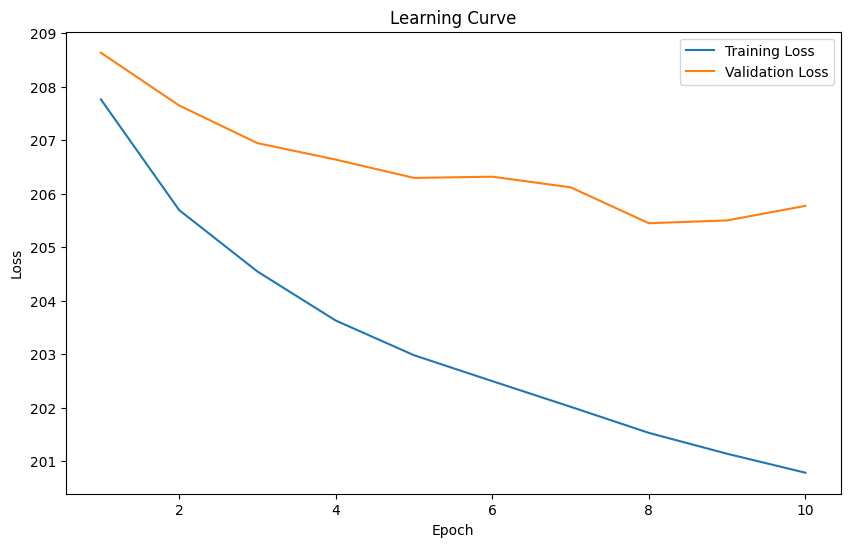

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
import torch
import numpy as np

def normalize_point_cloud(pc):
    """
    Normalize the point cloud to have zero mean and unit variance.
    """
    centroid = pc.mean(axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    if m == 0:
        return pc  # Avoid division by zero if m is zero
    return pc / m

def calculate_tre(transformed_x, target_x):
    """
    Calculate the Target Registration Error (TRE).
    :param transformed_x: Transformed source point cloud (torch.Tensor or np.ndarray).
    :param target_x: Target point cloud (torch.Tensor or np.ndarray).
    :return: TRE value.
    """
    if isinstance(transformed_x, torch.Tensor):
        transformed_x = transformed_x.cpu().numpy()  # Convert to NumPy array if necessary
    if isinstance(target_x, torch.Tensor):
        target_x = target_x.cpu().numpy()  # Convert to NumPy array if necessary

    # Ensure transformed_x and target_x are NumPy arrays with the same shape
    if transformed_x.shape != target_x.shape:
        raise ValueError("Shape mismatch: transformed_x and target_x must have the same shape")

    # Normalize both point clouds to the same scale
    transformed_x = normalize_point_cloud(transformed_x)
    target_x = normalize_point_cloud(target_x)

    # Calculate the Euclidean distances between corresponding points
    distances = np.linalg.norm(transformed_x - target_x, axis=1)

    # Calculate the average TRE
    tre = np.mean(distances)
    return tre

In [ ]:
def normalize_to_range(tensor, min_val, max_val):
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)  # Normalize to [0, 1]
    normalized_tensor = normalized_tensor * (max_val - min_val) + min_val  # Scale to [min_val, max_val]
    return normalized_tensor

def test_model(model, source_test, target_test, num_points):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_tre = 0.0

    with torch.no_grad():
        for source_x, target_x in zip(source_test, target_test):
            source_x, target_x = source_x.to(device), target_x.to(device)  # Move tensors to GPU
            transformed_x = model(source_x, target_x)  # Forward pass

            # Normalize transformed_x to the range of source_x
            source_min, source_max = source_x.min().item(), source_x.max().item()
            transformed_x = normalize_to_range(transformed_x, source_min, source_max)

            loss, _ = criterion(transformed_x.reshape(1, num_points, 3), target_x.reshape(1, num_points, 3))
            test_loss += loss.item()

            transformed_x_np = transformed_x.detach().cpu().numpy()
            target_x_np = target_x.detach().cpu().numpy()
            tre = calculate_tre(transformed_x_np, target_x_np)
            total_tre += tre

    average_test_loss = test_loss / len(source_test)
    average_tre = total_tre / len(source_test)

    print(f'Average Test Loss: {average_test_loss:.4f}')
    print(f'Average TRE: {average_tre:.4f}')

    return transformed_x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models and move to GPU
num_points = 2000
model = UpperNetwork(num_points=num_points).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Load the saved model
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
training_losses = checkpoint['training_losses']
validation_losses = checkpoint['validation_losses']
epoch = checkpoint['epoch']

# Ensure optimizer is on the correct device
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [ ]:
def test_model_plot(source_x_test, target_x_test):
    model.eval()  # Set the model to evaluation mode
    source_x_test = source_x_test.to(device)
    target_x_test = target_x_test.to(device)
    transformed_x_test = test_model(model, [source_x_test], [target_x_test], num_points)
    # transformed_x_test = source_x_test
    chamfer_dist, _ = compute_chamfer_distance(transformed_x_test.reshape(1, num_points, 3), target_x_test.reshape(1, num_points, 3))
    print(f'Chamfer Distance after prediction: {chamfer_dist:.4f}')
    transformed_x_np = transformed_x_test[0].detach().cpu().numpy()
    target_x_np = target_x_test[0].detach().cpu().numpy()
    source_x_np = source_x_test[0].detach().cpu().numpy()

    fig = plt.figure(figsize=(24, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(target_x_np[0, :], target_x_np[1, :], target_x_np[2, :], c='blue')
    ax1.set_title('Target Point Cloud')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(transformed_x_np[0, :], transformed_x_np[1, :], transformed_x_np[2, :], c='red')
    ax2.set_title('Transformed Point Cloud')

    ax3 = fig.add_subplot(132, projection='3d')
    ax3.scatter(source_x_np[0, :], source_x_np[1, :], source_x_np[2, :], c='green')
    ax3.set_title('Source Point Cloud')

    plt.show()

Average Test Loss: 212.4769
Average TRE: 106.2765
Chamfer Distance after prediction: 212.4769


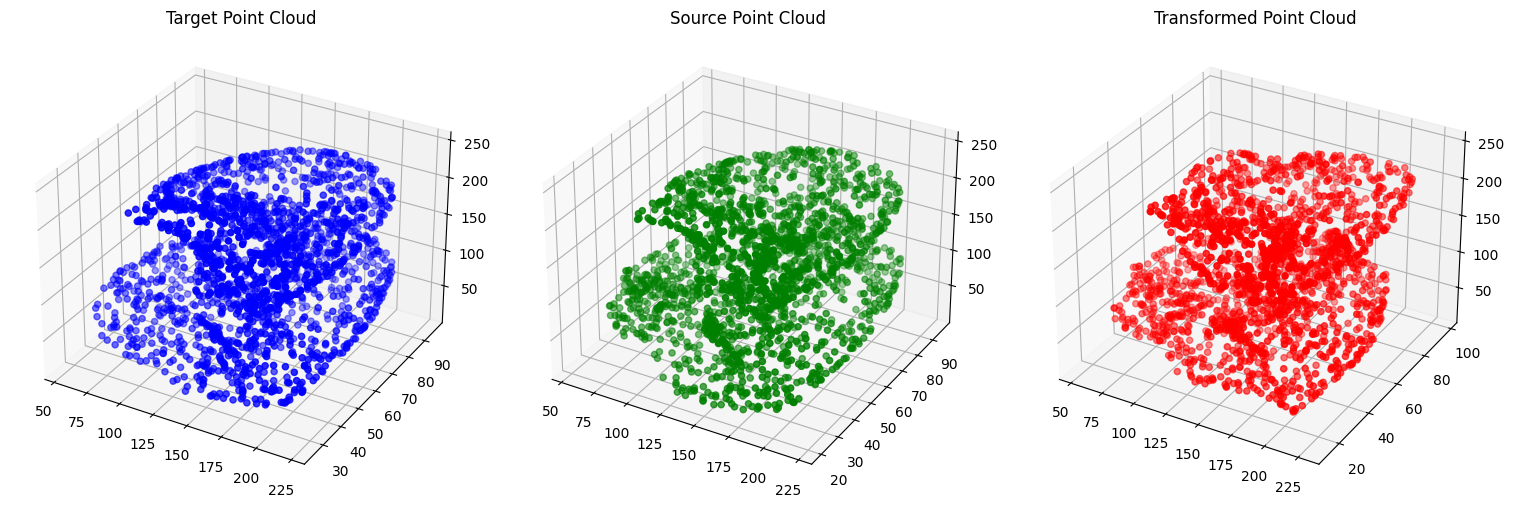

In [ ]:
test_source_file = ['/content/drive/MyDrive/points/case5/case5_T00.txt']
test_target_file = ['/content/drive/MyDrive/points/case5/case5_T50.txt']
source_x_test = load_point_cloud(test_source_file[0])
target_x_test = load_point_cloud(test_target_file[0])
test_model_plot(source_x_test, target_x_test)

In [ ]:
def test_all_landmarks():
  source = []
  target = []
  for i in range(1,6):
    for j in range(10):
      source.append('/content/drive/MyDrive/Case' + str(i) + 'Pack' + '/Sampled4D' + '/case' + str(i) + '_4D-75_T' + str(j) + '0.txt')
      target.append('/content/drive/MyDrive/Case' + str(i) + 'Pack' + '/Sampled4D' + '/case' + str(i) + '_4D-75_T' + str(j) + '0.txt')

  combinations = [
      (s, t)
      for s in source
      for t in target
  ]

  source_combinations = [combo[0] for combo in combinations]
  target_combinations = [combo[1] for combo in combinations]
  for i in range(len(source_combinations)):
    if os.path.exists(source_combinations[i]) and os.path.exists(target_combinations[i]):
        source_x_test = load_point_cloud(source_combinations[i])
        target_x_test = load_point_cloud(target_combinations[i])
        test_model_plot(source_x_test, target_x_test)


In [ ]:
test_all_landmarks()

In [ ]:
from sklearn.metrics import mean_squared_error

def compute_rmse(transformed, target):
    transformed_flat = transformed.view(-1, 3).cpu().detach().numpy()
    target_flat = target.view(-1, 3).cpu().detach().numpy()

    return np.sqrt(mean_squared_error(transformed_flat, target_flat))